## Set-up

In [1]:
# First run:
# bin\OpenPoseDemo.exe --video="C:\Users\jaspe\tf-openpose\clips\20180205_185116.mp4" --write_json=coordinates --keypoint_scale=0

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import cv2 
# pip install .whl file from https://www.lfd.uci.edu/~gohlke/pythonlibs/#opencv
# pip install numpy --upgrade if numpy.multiarray error

import time
import math

from itertools import chain

from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import pairwise_distances
from math import sqrt

In [3]:
def rmse(a,b):
    return sqrt(mean_squared_error(a,b))

In [4]:
cam = cv2.VideoCapture(r'C:\Users\jaspe\tf-openpose\clips\20180205_185116.mp4')
ret_val, image = cam.read()
image_h, image_w = image.shape[:2]
fps = cam.get(cv2.CAP_PROP_FPS)

In [5]:
% matplotlib inline

In [6]:
connections = [
    (1,2), (1,5), (2,3), (3,4), (5,6), (6,7), (1,8), (8,9), (9,10), (1,11), (11,12), (12,13), (1,0), (0,14), (14,16),
    (0,15), (15,17), (2,16), (5,17)
                ]

In [7]:
people_per_file = []

for path, subdirs, files in os.walk(r'C:\Users\jaspe\tf-openpose\demo\openpose-1.2.1-win64-binaries\coordinates'):
    for filename in files:
        coord_path = os.path.join(path, filename)
        with open(coord_path) as f:
            people_per_file.append(json.load(f)['people'])

## Getting plottable information per file

In [8]:
plottables_per_file = []
period_person_division = {}
next_person = 0

for period, file in enumerate(people_per_file):
    period_person_division[period] = {}
    plot_lines = []
    plot_coords = []
    plottables = {}
    
    coords = []
    for person in file:
        coords.append(np.array([[x,-y,z] for x,y,z in np.reshape(person['pose_keypoints'], (18,3))]))
        
        person_coords = np.array([[x,-y] for x,y,z in np.reshape(person['pose_keypoints'], (18,3))])
        empty_joints = set(np.where((person_coords==0).all(axis=1))[0])
        
        ### Identifying people over subsequent frames ###
        
        best_person_fit = None
        if period != 0:
            min_rmse = 1000
            used_joints = list(set(range(18))-empty_joints)
            cx = np.mean(person_coords[used_joints,0])
            cy = np.mean(person_coords[used_joints,1])
            rmse_threshold = np.mean(pairwise_distances(np.array((cx, cy)).reshape(1,2), 
                                                        person_coords[used_joints, :]))
            
            max_frame_diff = int(fps//3)
            if period < max_frame_diff:
                j = period
            else:
                j = max_frame_diff
                
            for i in range(1,j+1):
                for earlier_person in period_person_division[period-i].keys():
                    if earlier_person not in period_person_division[period].keys():
                        earlier_person_coords = period_person_division[period-i][earlier_person]
                        empty_joints_copy = empty_joints.copy()
                        empty_joints_copy = empty_joints_copy | set(np.where((earlier_person_coords==0).all(axis=1))[0])
                        used_joints = list(set(range(18)) - empty_joints_copy)
                        if len(used_joints) == 0:
                            continue
                        person_distance = rmse(earlier_person_coords[used_joints,:], person_coords[used_joints,:])
                        if person_distance < rmse_threshold:
                            if person_distance < min_rmse:
                                min_rmse = person_distance
                                best_person_fit = earlier_person
            if best_person_fit != None:
                period_person_division[period][best_person_fit] = person_coords
            else:
                period_person_division[period][next_person] = person_coords
                next_person += 1
        else:
            period_person_division[period][next_person] = person_coords
            next_person += 1
            
    for person_coords in coords:
        try:
            plot_coords = plot_coords + list(person_coords[~(person_coords==0).any(axis=1)])
        except:
            continue

        coord_dict = {key:value for key, value in  dict(enumerate(person_coords[:, :2])).items() if 0 not in value}

        present_keypoints = set(coord_dict.keys())

        present_connections = [connection for connection in connections if len(present_keypoints&set(connection)) == 2]

        plot_lines = plot_lines + [np.transpose([coord_dict[a], coord_dict[b]]) for a,b in present_connections]
        
    if len(plot_coords) == 0:
        continue
    
    plot_coords = np.array(plot_coords)
    
    plottables['plot_coords'] = plot_coords
    plottables['plot_lines'] = plot_lines
    
    plottables_per_file.append(plottables)

## Plotting video

In [9]:
def plot_fit(plottables_per_file, period, f, ax):
    
    plot_coords = plottables_per_file[period]['plot_coords']
    plot_lines = plottables_per_file[period]['plot_lines']
    
    plt.scatter(x=plot_coords[:, 0], y=plot_coords[:, 1])

    for x, y in plot_lines:
        plt.plot(x, y)

    ax.set_xlim([0, image_w])
    ax.set_ylim([-image_h, 0])
    
    f.canvas.draw()
    ax.clear()

In [10]:
% matplotlib notebook

<IPython.core.display.Javascript object>


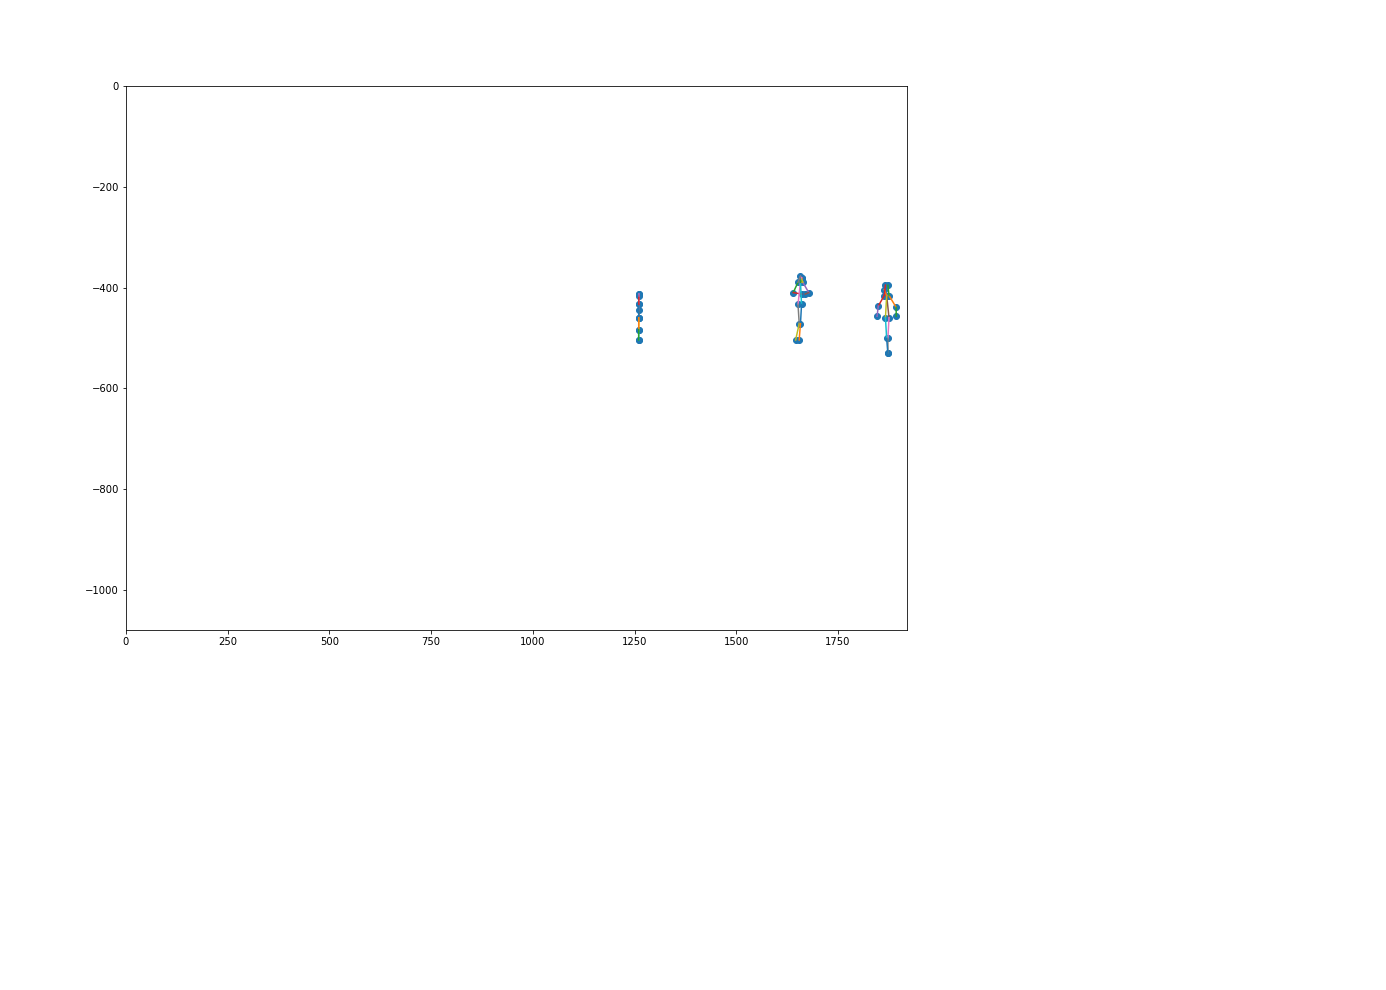

In [11]:
f, ax = plt.subplots(figsize=(14,10))
xspeed = 4

for t in range(0, len(plottables_per_file)):
    plot_fit(plottables_per_file, period=t, f=f, ax=ax)
#     time.sleep(1/fps/xspeed)

## Extracting person under observation

In [12]:
# Basically change the layout of the dictionary
# Now you first index based on the person and then you index based on the period

person_period_division = {}
for person in set(chain.from_iterable(period_person_division.values())):
    person_period_division[person] = {}
    for period in period_person_division.keys():
        period_dictionary = period_person_division[period]
        if person in period_dictionary:
            person_period_division[person][period] = period_dictionary[person]

In [13]:
# Calculate the mean x-position of a person in a certain period

mean_x_per_person = {person:{period:np.mean(coords[~(coords==0).any(axis=1),0]) 
                             for period,coords in time_coord_dict.items()} 
                             for person,time_coord_dict in person_period_division.items()}

In [14]:
# Calculate moved distance by summing the absolute difference over periods
# Normalize moved distance per identified person over frames by including the average frame difference and the length
# of the number of frames included

normalized_moved_distance_per_person = \
{person:pd.Series(mean_x_dict).diff().abs().sum()/(np.diff(pd.Series(mean_x_dict).index).mean()*len(mean_x_dict)) 
     for person, mean_x_dict in mean_x_per_person.items()}

C:\Users\jaspe\AppData\Roaming\Python\Python35\site-packages\ipykernel\__main__.py:6: RuntimeWarning: Mean of empty slice.
C:\Users\jaspe\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
# Only include identified people that move more than a set movement threshold

maximum_normalized_distance = max(normalized_moved_distance_per_person.values())
movement_threshold = maximum_normalized_distance/4
moving_people = [key for key,value in normalized_moved_distance_per_person.items() if value > movement_threshold]

In [16]:
person_plottables_df = \
pd.DataFrame([(period, person, x) for person,period_dict in mean_x_per_person.items() if person in moving_people 
              for period,x in period_dict.items()], columns=['Period', 'Person', 'X mean'])

In [17]:
%matplotlib inline

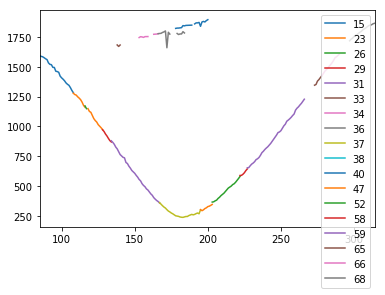

In [18]:
pd.DataFrame({key:value for key,value in mean_x_per_person.items() if key in moving_people}).plot()

In [19]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=maximum_normalized_distance*2, min_samples=1)

db.fit(person_plottables_df[['Period', 'X mean']])

person_plottables_df['labels'] = db.labels_

maximum_label = person_plottables_df.groupby('labels').apply(len).sort_values(ascending=False).index[0]

plottable_people = person_plottables_df[person_plottables_df['labels']==maximum_label]['Person'].unique()

In [20]:
person_plottables = [value for period_dictionary in period_person_division.values() 
                     for key,value in period_dictionary.items() if key in plottable_people]

In [21]:
def plot_person(person_plottables, period, f, ax):
    
    plot_coords = person_plottables[period]
    
    coord_dict = {key:value for key, value in dict(enumerate(plot_coords)).items() if 0 not in value}

    present_keypoints = set(coord_dict.keys())

    present_connections = [connection for connection in connections if len(present_keypoints&set(connection)) == 2]

    plot_lines = [np.transpose([coord_dict[a], coord_dict[b]]) for a,b in present_connections]
    
    plot_coords = plot_coords[~(plot_coords==0).any(axis=1)]
    
    plt.scatter(x=plot_coords[:, 0], y=plot_coords[:, 1])
    
    for x, y in plot_lines:
        plt.plot(x, y)

    ax.set_xlim([plot_coords[:,0].min()-100, plot_coords[:,0].max()+100])
    ax.set_ylim([plot_coords[:,1].min()-100, plot_coords[:,1].max()+100])
    
#     ax.set_xlim([0, image_w])
#     ax.set_ylim([-image_h, 0])
    
    f.canvas.draw()
    ax.clear()

In [22]:
% matplotlib notebook

<IPython.core.display.Javascript object>


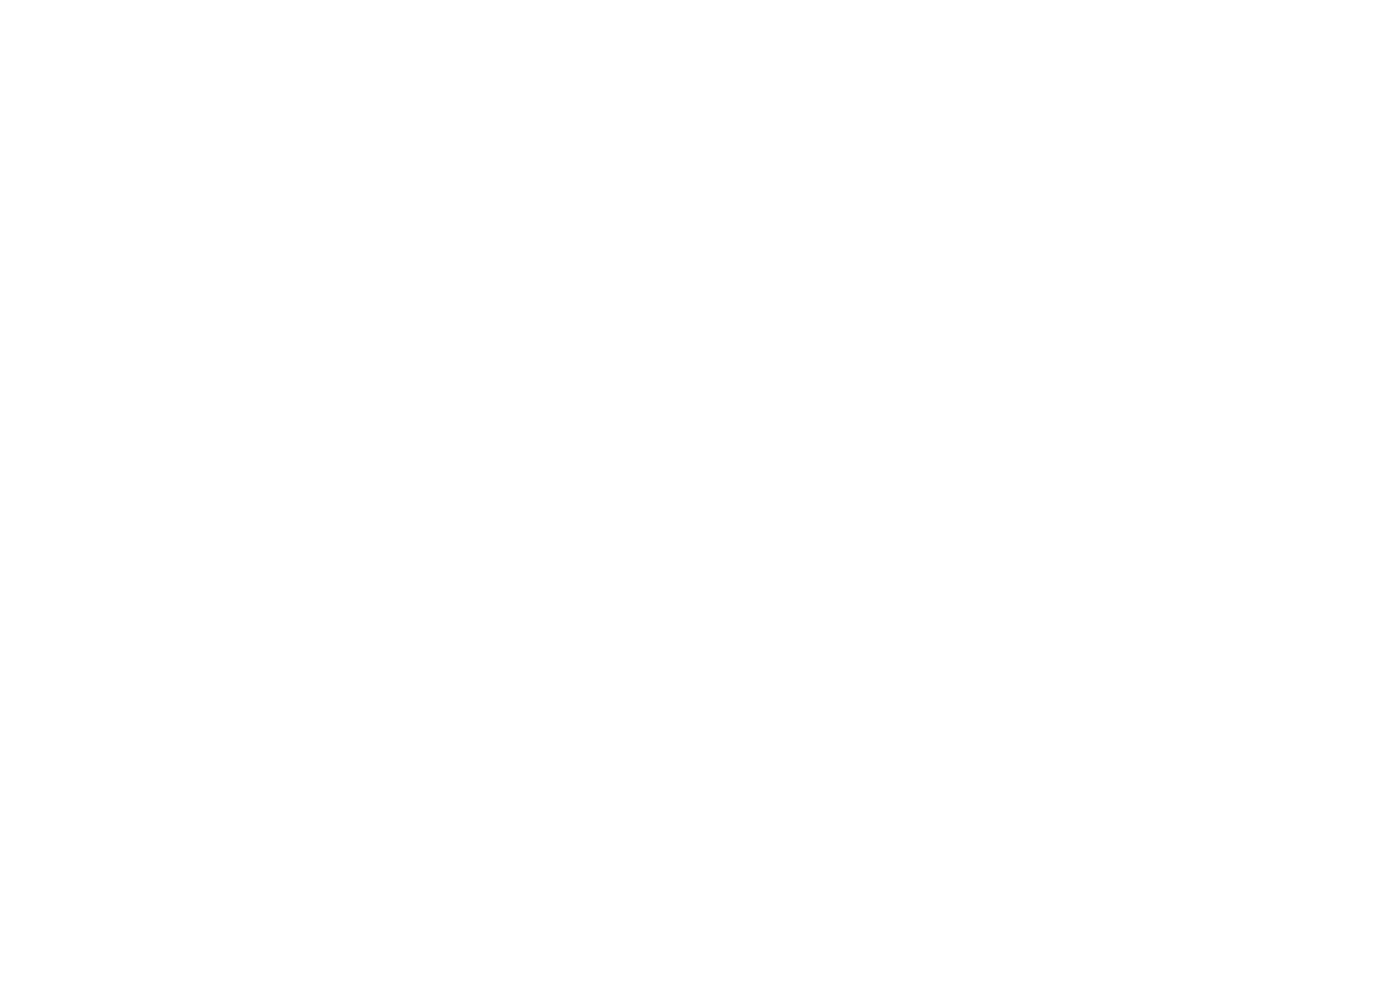

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


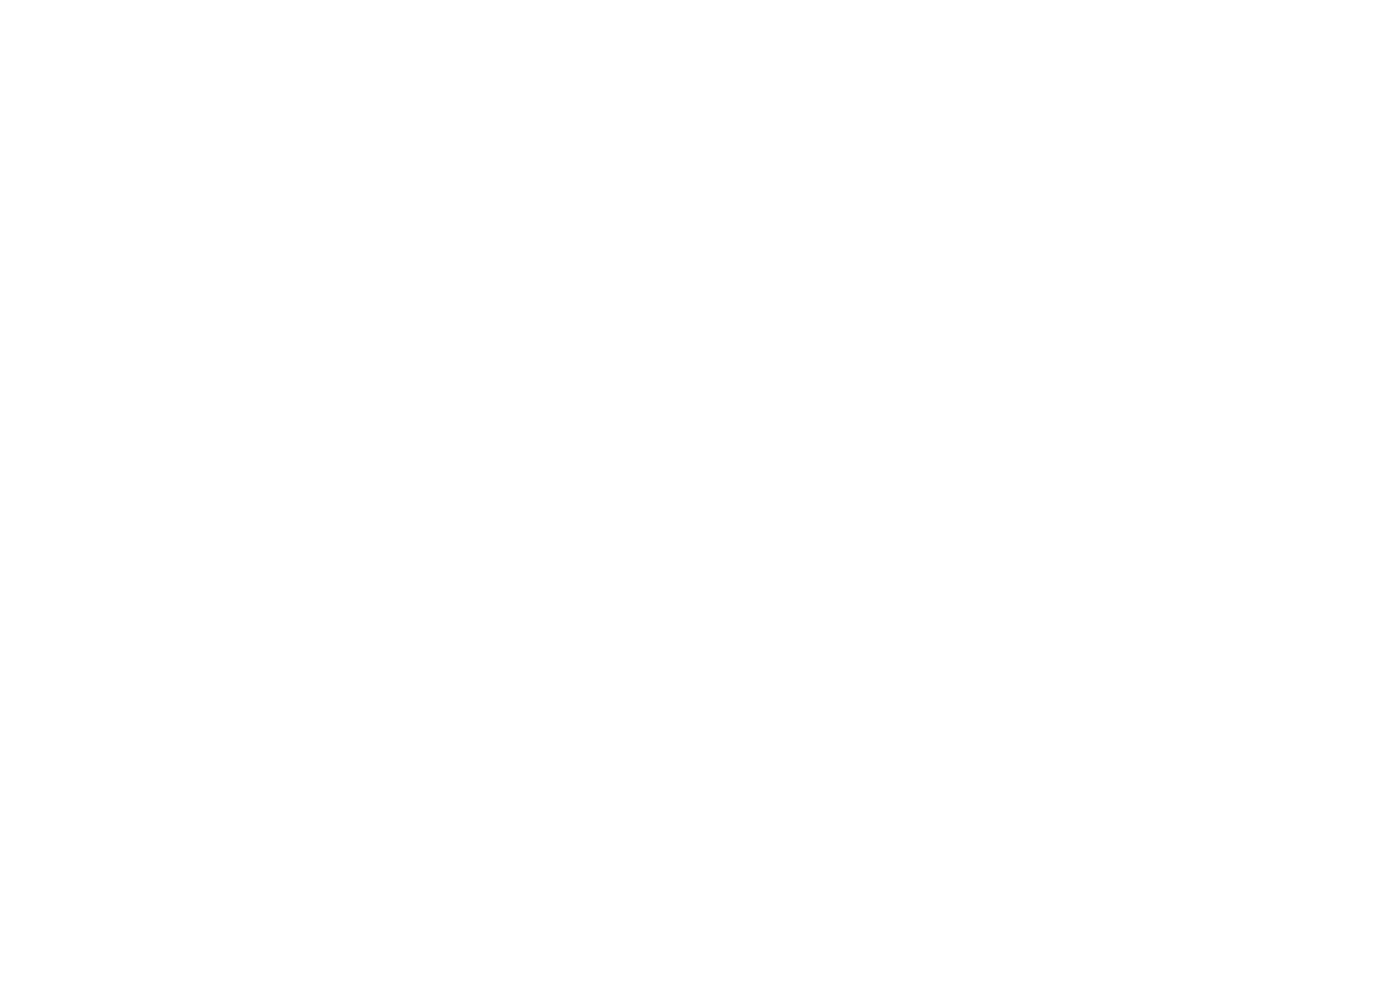

In [23]:
f, ax = plt.subplots(figsize=(14,10))

for t in range(0, len(person_plottables)):
    plot_person(person_plottables, period=t, f=f, ax=ax)
    time.sleep(1/fps)